In [1]:
import sys
sys.path.append('..')

import myfcns
import model
import agents

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import rosen, differential_evolution, minimize, basinhopping, brute,fmin
from mpl_toolkits.mplot3d import Axes3D

import os
import sys
import time
import csv
import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns
from ptitprince import PtitPrince as pt


from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
'''
/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: 
The `IPython.html` package has been deprecated since IPython 4.0. 
You should import from `notebook` instead. 
`IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
'''

import random as rd
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN


/Users/arataNonami/opt/anaconda3/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# my fcn

def a2s(x):  # 呼び出すときは、np.fromstring(txt, sep=',')
    x = np.array(x).flatten()
    return np.array2string(x, precision=2, separator=',',suppress_small=True)[1:-1]
def plot4d(x,y,z,c,title=""):
    fig = plt.figure()
    ax1 = fig.add_subplot(projection='3d')
    c = c / min(c)
    sc = ax1.scatter(x,y,z,zdir='z', c=c, cmap=plt.cm.autumn.reversed())  #binary
    plt.colorbar(sc)
    plt.title(title)
    return
choice2idx = {"left":0, "middle":1, "right":2}
idx2choice = np.array(["left", "middle", "right"])

files = myfcns.get_file_name("log")
game_filename = "rateTable_size20_300trials_0004.csv"
#log = model.GameFromLog(log_filename)

## 全て、当たり確率最大を選べた時の、得点の期待値

In [3]:


files = myfcns.get_file_name("log")
sum_probs = []
a = []
for file in files:
    gfl = model.GameFromLog(file)
    log = gfl.log
    sum_prob = 0
    for i in range(299):
        probs = np.array([log.prob_left[i], log.prob_middle[i], log.prob_right[i]])
        sum_prob += max(probs)
    a.append(sum_prob)
    sum_probs.append(sum_prob)
    #print(sum_prob)
print(sum_probs)


[234.02000000000015, 233.45999999999998, 234.03999999999996, 237.89999999999998, 236.57999999999996, 227.40000000000003, 232.87999999999997, 235.25999999999988, 237.18999999999997, 231.8099999999998, 239.42000000000004, 237.95999999999995, 234.23999999999992, 230.28999999999985, 233.55000000000007]


In [306]:
print("↓どれだけ上手く選んでも、理論値の最大得点の期待値は、\n{}問 * 10点".format(sum(sum_probs)/ len(sum_probs)))

↓どれだけ上手く選んでも、理論値の最大得点の期待値は、
234.4問 * 10点


## 正しい選択率

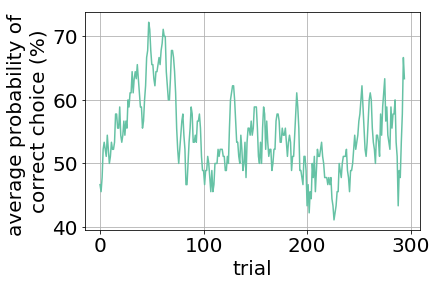

In [12]:
num_correct_choice = np.zeros(300)
for file in files:
    gfl = model.GameFromLog(file)
    log = gfl.log
    
    for i in range(299):
        probs = np.array([log.prob_left[i], log.prob_middle[i], log.prob_right[i]])
        if probs[choice2idx[log.choice[i]]] == max(probs):
            num_correct_choice[i] += 1
xx = 100.0*num_correct_choice/len(files)
x = []
n =5 #number of trials to calc average
for i in range(len(xx)-n):
    x.append(sum(xx[i:i+n]) / (n+1)) 
sns.set_palette("Set2")
plt.plot(x)

plt.rcParams["font.size"] = 20
plt.xlabel('trial')
plt.ylabel('average probability of \ncorrect choice (%)')
plt.grid()

# 順序で下の選択肢を選んでいないかどうか

## 各columnの意味
● n_competitive: 選択肢の順序を考慮した時に、明らかに当たり確率が高いものが存在しなかったtrial数。（ex. 濃い星二つ、などは、明らかに当たり確率が順序列より有意であることが分かるため、not-competitive）  
● competitive_rate: competitiveなtrialの出現率。実験デザインでは85%に設定されているので、その前後であることの確認  
● n_sum_of_order: 幾つの選択肢で迷うか。n_sum_of_order_1は、「一つの選択肢で迷うtrial」つまり順序列を考慮すると迷うはずのない選択肢の組み合わせが出現したtrialの回数  
● inferior_choice: 順序列を考慮した時に、明らかに当たり確率が低い選択肢が選ばれている確率。これが大きいと、ルールの理解が不足している可能性が考えられる。  
● best_prob_choice: 最も当たり確率が高い選択肢を選べていたtrial数。  
● attraction_effect_choice_rate: attraction effectが生まれてしまったtrialの出現確率。つまり、2つの選択肢で迷うようなtrial　(sum(order)=2)において、劣る一つの選択肢の影響で、選択に影響を与えてしまった確率。  
ex. op1>op3, op1=op2, op2=op3,の時に、op1が選ばれる確率。valueに基づいてop1が選ばれる確率は理論値50%なので、50%を有意に超えているかどうか、が議論の対象。  （実際は理論値は50%ではないので、計算が必要かもしれない。）


In [271]:
class A:
    def __init__(self):
        self.score = 0
        self.n_competitive = 0
        self.competitive_choice = 0
        self.n_sum_of_order = [0,0,0]
        self.inferior_choice = 0
        self.best_prob_choice = []
        self.best_prob_choice_without_non_competitive = []
        self.attraction_effect_choice_rate = 0
        return
    def my_print(self):
        return([self.score,
                self.n_competitive,
                self.n_competitive / 3,
                self.n_sum_of_order[0],
                self.n_sum_of_order[1],
                self.n_sum_of_order[2],
                self.competitive_choice,
                self.inferior_choice,
                sum(self.best_prob_choice),
                sum(self.best_prob_choice_without_non_competitive)/(self.n_sum_of_order[1]+self.n_sum_of_order[2])*100,
                self.attraction_effect_choice_rate])
def get_competitive_choice_history(file):
    a = A()
    gfl = model.GameFromLog(file)
    log = gfl.log
    orders = []
    a.score = log.sum_score[299]
    possible_trial_of_attraction_effect = 0
    for i in range(300):
        ops = [log.option_left[i], log.option_middle[i], log.option_right[i]]
        probs = np.array([log.prob_left[i], log.prob_middle[i], log.prob_right[i]])
        choice = choice2idx[log.choice[i]]

        order = np.array(gfl.if_competitive(ops[0], ops[1], ops[2]))
        orders.append(sum(order))
        a.n_sum_of_order[sum(order) - 1] += 1
        
        if_best_prob_choice = (idx2choice[probs == max(probs)] == log.choice[i]).all()
        a.best_prob_choice.append(if_best_prob_choice)
        
        if(sum(order) >= 2):
            a.n_competitive = a.n_competitive + 1
            a.best_prob_choice_without_non_competitive.append(if_best_prob_choice)
        if(sum(order) == 2):
            idxs = np.array([0,1,2])[order == 1]
            inf_op = np.array([0,1,2])[order == 0][0]
            
            #print([idxs, inf_op])
            #print(ops[inf_op])
            #print(gfl.compare(ops[idxs[0]], ops[inf_op]))

            if(gfl.compare(ops[idxs[0]], ops[inf_op]) == "left_is_bigger"):
                if(gfl.compare(ops[idxs[1]], ops[inf_op]) == "these_are_comparable"):
                    possible_trial_of_attraction_effect += 1
                    if(choice == idxs[0]):
                        a.attraction_effect_choice_rate += 1
            if(gfl.compare(ops[idxs[0]], ops[inf_op]) == "these_are_comparable"):
                if(gfl.compare(ops[idxs[1]], ops[inf_op]) == "left_is_bigger"):
                    possible_trial_of_attraction_effect += 1
                    if(choice == idxs[1]):
                        a.attraction_effect_choice_rate += 1
        if(order[choice] == 1):
            a.competitive_choice = a.competitive_choice + 1
            continue
        a.inferior_choice = a.inferior_choice+1
    a.attraction_effect_choice_rate = 100.0*a.attraction_effect_choice_rate/possible_trial_of_attraction_effect
    return a.my_print()

In [273]:
columns = ["score", "n_competitive", "n_competitive_rate(%)",
           "n_sum_of_order_1", "n_sum_of_order_2", "n_sum_of_order_3", 
           "competitive_choice", "inferior_choice", 
           "best_prob_choice","best_prob_choice_rate_without_non_competitive(%)",
           "attraction_effect_choice_rate"]
df = pd.DataFrame(columns=columns)
for file in files:
    h = get_competitive_choice_history(file)
    hdf = pd.DataFrame([h], columns=columns, index=[file])
    df = df.append(hdf)
print(df)
#df.to_csv("init_anal.csv")

           score n_competitive  n_competitive_rate(%) n_sum_of_order_1  \
log/01.csv  1980           270              90.000000               30   
log/02.csv  2020           277              92.333333               23   
log/03.csv  1990           273              91.000000               27   
log/04.csv  2030           268              89.333333               32   
log/05.csv  1870           266              88.666667               34   
log/06.csv  1870           278              92.666667               22   
log/07.csv  2060           273              91.000000               27   
log/08.csv  1880           273              91.000000               27   
log/09.csv  1950           271              90.333333               29   
log/10.csv  2020           260              86.666667               40   
log/11.csv  1870           264              88.000000               36   
log/12.csv  2080           260              86.666667               40   
log/13.csv  2050           274        

In [274]:
df.to_csv("init_anal.csv")

In [ ]:
## ここまでと、fittingを受けた所見
fittingのbetaの値が大きすぎる。
best_prob_choiceがせいぜい70%, 低い時には60%くらいなので、
betaがそこまで大きくなっていると、30%のぶんのトライアルでLLが下がりそうなものなのだが。

LLの取り方がよろしくないのだろうか。

# Fittingのデータの簡易分析

Text(0.5, 0, '順序の小さい刺激を選んだ回数')

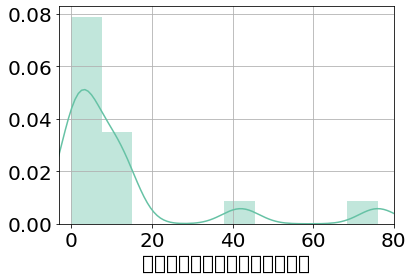

In [19]:
df = pd.read_csv('init_anal.csv')
sns.distplot(df.inferior_choice)
plt.xlim([-3,80])
plt.grid()
plt.rcParams["font.family"] = "IPAexGothic"

plt.xlabel('')  # 順序の小さい刺激を選んだ回数